# Import lib

In [24]:
import os
import cv2
import zipfile
import random
import glob
import shutil
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from os import makedirs
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Now Dir:", os.getcwd())
print("Tensorflow:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Now Dir: /usr/local/share_storages/lab
Tensorflow: 2.8.0
Num GPUs Available:  0


# Dowload, Unzip and Verify dataset

First of all You need dowload dataset from https://www.kaggle.com/c/dogs-vs-cats/data and save into ```/usr/local/share_storages/data/dataset/dogs-vs-cats.zip```
after that unzip like below.
```python
├── jupyterlab -> contains config jupyterlab
├── share_storages
    ├── lab -> All notebook
    ├── data -> public data like image, ai-model, csv ..
        ├── dataset
            ├── dogs-vs-cats
                ├── train
                ├── test1
            ...
        ├── image
        ├── model
├── docker-compose.yaml -> run server
...
```

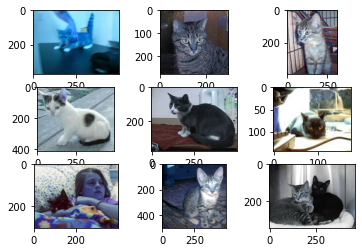

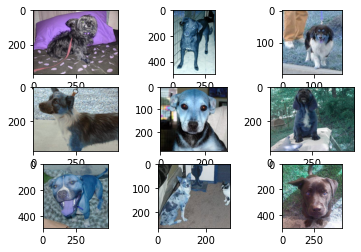

In [27]:
# 1. Unzip datasets 
DATASET_PATH = '/usr/local/share_storages/data/dataset/dogs-vs-cats'
DATASET_ZIP_PATH = DATASET_PATH + '.zip'

zip_ref = zipfile.ZipFile(DATASET_ZIP_PATH, "r").extractall(DATASET_PATH)
zip_ref = zipfile.ZipFile(DATASET_PATH + '/train.zip', "r").extractall(DATASET_PATH)
zip_ref = zipfile.ZipFile(DATASET_PATH + '/test1.zip', "r").extractall(DATASET_PATH)

# 2. Show sample dataset
folder = '/usr/local/share_storages/data/dataset/dogs-vs-cats/train/'
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = cv2.imread(filename)
    plt.imshow(image)
plt.show()
print('         ==============================')
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = cv2.imread(filename)
    plt.imshow(image)
plt.show()

# 3. Prepare train, test data

- structure data set with random image from train folder and split random into 75% train and 25% test folder. 
- We using test1 folder for benchmark model.

```python
├── dataset
    ├── dogs-vs-cats
        ├── test1 -> using for benchmark model.
        ├── train -> using for training model (have been restructure for easy using ImageDataGenerator).
            ├── train
                ├── dogs
                ├── cats
            ├── test
                ├── dogs
                ├── cats
```

In [63]:
train_dataset_path = '/usr/local/share_storages/data/dataset/dogs-vs-cats/train/'
train_ratio = 0.75
sub_dirs = ['train/', 'test/']
class_dirs = ['dogs/', 'cats/']

# restructure for easy create dataset with ImageDataGenerator
for sub in sub_dirs:
    for class_dir in class_dirs:
        makedirs(train_dataset_path + sub + class_dir, exist_ok=True)


# Random 75% to train and 25% to test
cats = glob.glob(train_dataset_path + 'cat.*')
dogs = glob.glob(train_dataset_path + 'dog.*')
random.shuffle(dogs)
random.shuffle(cats)
cat_trains = cats[:int((len(cats)+1)*train_ratio)]
dog_trains = dogs[:int((len(dogs)+1)*train_ratio)]
cat_tests = cats[int((len(cats)+1)*train_ratio):] 
dog_tests = dogs[int((len(dogs)+1)*train_ratio):]
print("Train with Dog: {}, Cat: {}".format(len(dog_trains), len(cat_trains)))
print("Test with Dog: {}, Cat: {}".format(len(dog_tests), len(cat_tests)))

# # Move data to new structure
for path in tqdm(cat_trains): shutil.move(path, train_dataset_path + sub_dirs[0] + class_dirs[1] + path.split("/")[-1])
for path in tqdm(dog_trains): shutil.move(path, train_dataset_path + sub_dirs[0] + class_dirs[0] + path.split("/")[-1])
for path in tqdm(cat_tests): shutil.move(path, train_dataset_path + sub_dirs[1] + class_dirs[1] + path.split("/")[-1])
for path in tqdm(dog_tests): shutil.move(path, train_dataset_path + sub_dirs[1] + class_dirs[0] + path.split("/")[-1])

Train with Dog: 9375, Cat: 9375
Test with Dog: 3125, Cat: 3125


100%|██████████| 3125/3125 [00:06<00:00, 485.41it/s]


# Define cnn model

In [2]:
#  VGG-3, dropout, and image data augmentation
def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    modell.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=default_opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Training and Save model

In [3]:
# Set the default optimizer
default_opt = Adam(learning_rate=0.001)

# load model
model = get_model()

# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory('/usr/local/share_storages/data/dataset/dogs-vs-cats/train/train/', class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = test_datagen.flow_from_directory('/usr/local/share_storages/data/dataset/dogs-vs-cats/train/test/', class_mode='binary', batch_size=64, target_size=(200, 200))

# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)

# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

2022-03-27 02:44:43.686004: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 681s 2s/step - loss: 0.9382 - accuracy: 0.5706 - val_loss: 0.6164 - val_accuracy: 0.6517
Epoch 2/50
293/293 [==============================] - 724s 2s/step - loss: 0.5985 - accuracy: 0.6703 - val_loss: 0.5553 - val_accuracy: 0.7075
Epoch 3/50
293/293 [==============================] - 683s 2s/step - loss: 0.5741 - accuracy: 0.6996 - val_loss: 0.5404 - val_accuracy: 0.7117
Epoch 4/50
293/293 [==============================] - 744s 3s/step - loss: 0.5540 - accuracy: 0.7141 - val_loss: 0.5344 - val_accuracy: 0.7205
Epoch 5/50
293/293 [==============================] - 745s 3s/step - loss: 0.5300 - accuracy: 0.7359 - val_loss: 0.5187 - val_accuracy: 0.7299
Epoch 6/50
293/293 [==============================] - 698s 2s/step - loss: 0.5047 - accuracy: 0.7557 - val_loss: 0.4816 - val_accuracy: 0.7650
Epoch 7/50
293/293 [==============================] - 675

In [8]:
# model.save("/usr/local/share_storages/data/model/cat-dog")
model.save('/usr/local/share_storages/data/model/cat-dog.h5')

# Sumarize Diagnostics

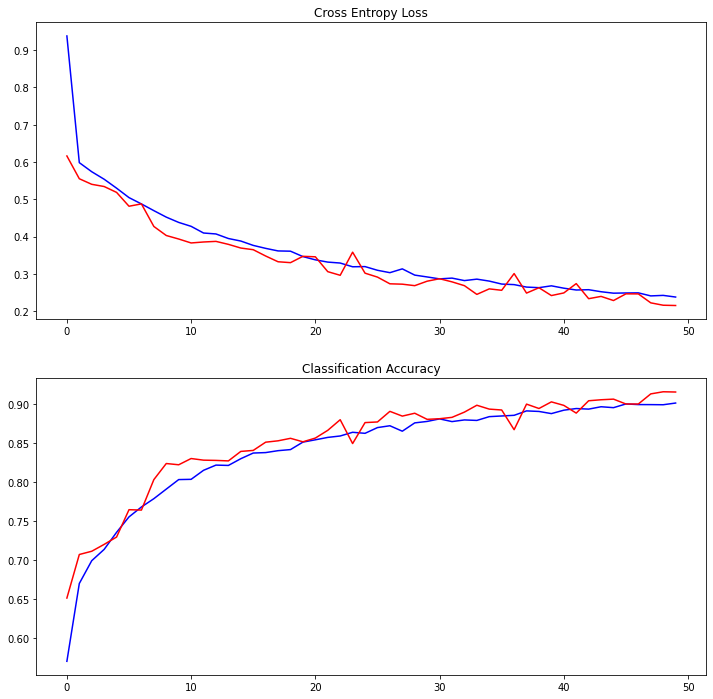

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	fig, axs = plt.subplots(2, 1, figsize=(12,12))
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='red', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='red', label='test')
	plt.show()
    
# learning curves
summarize_diagnostics(history)

# Test model

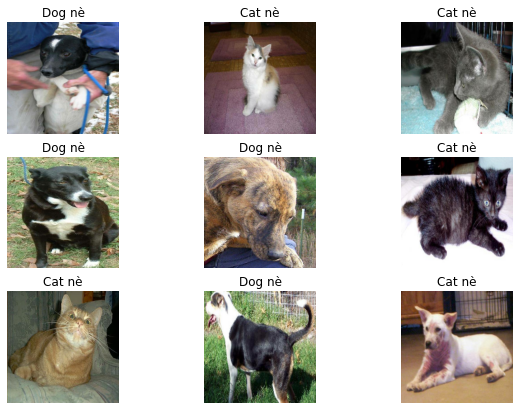

In [28]:
IMAGE_SIZE = 200

# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range
    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

images_paths = glob.glob("/usr/local/share_storages/data/dataset/dogs-vs-cats/test1/*.jpg")

rows = 3
plt.figure(figsize=(10,7))
for num, x in enumerate(images_paths[0:9]):
    image = load_and_preprocess_image(x)
    pred = model.predict(np.array([image]))
    if pred[0] > 0.5: class_name = 'Dog nè'
    else: class_name = 'Cat nè'
    plt.subplot(rows,3, num+1)
    plt.title(class_name)
    plt.axis('off')
    plt.imshow(image)
plt.show()